# Figure 1

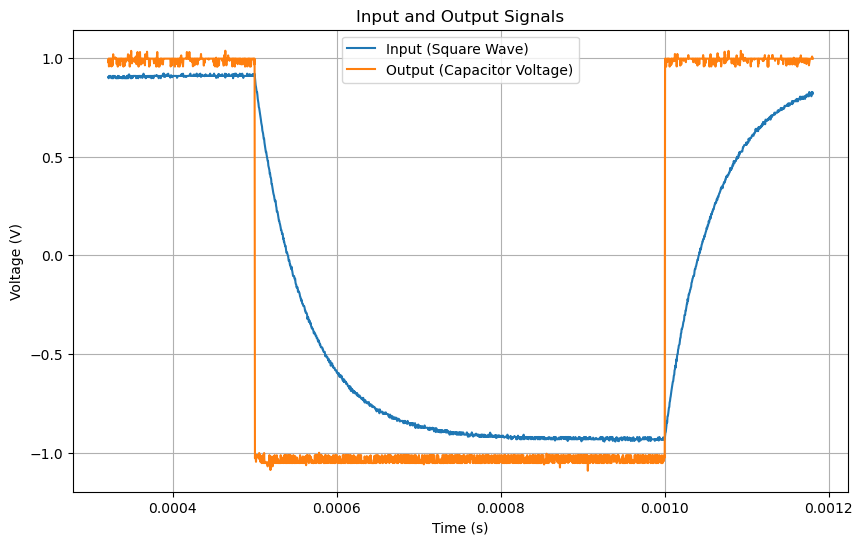

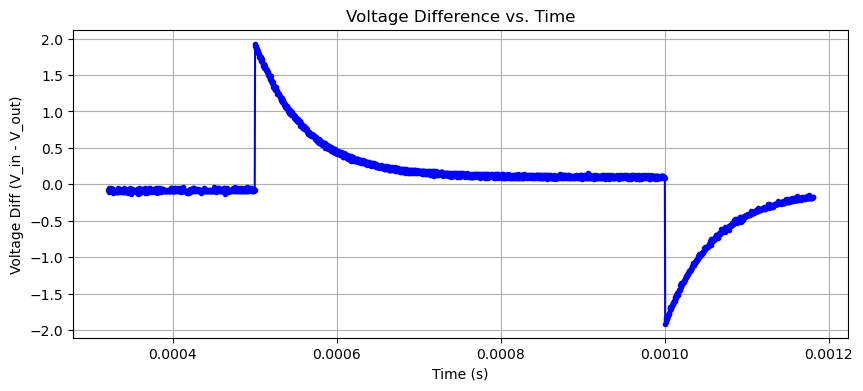

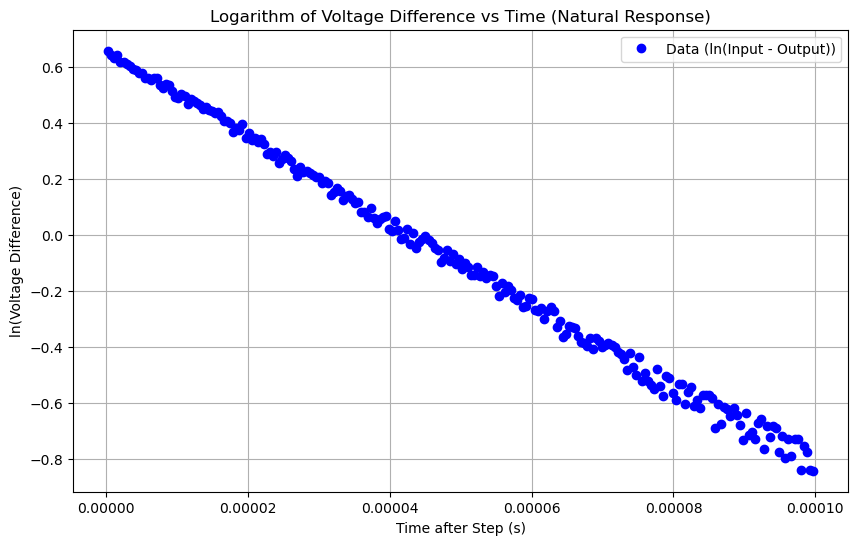

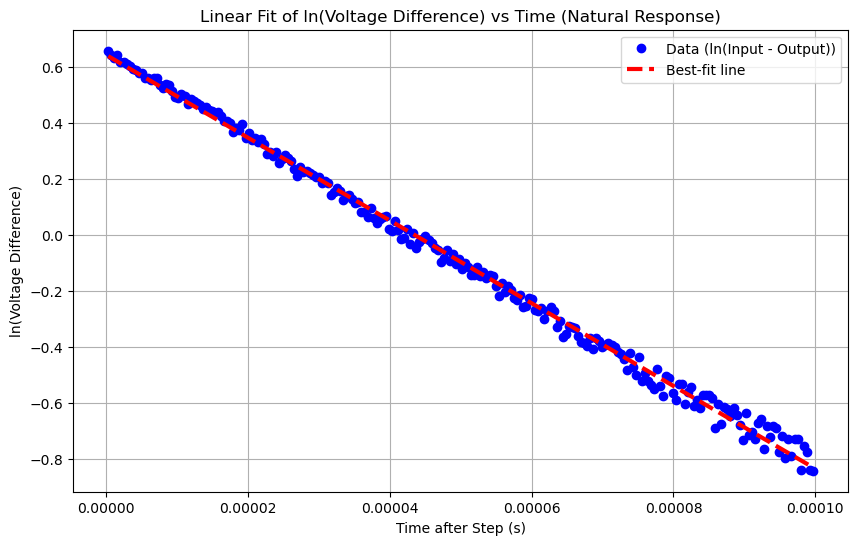

Intercept: 6.43e-01 ± 3.32e-03
Slope:     -1.48e+04 ± 5.75e+01
Measured time constant (tau): 6.76e-05 s ± 2.63e-07 s


In [87]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# --- Load the data (assumes CSV has columns: 'Time', 'Input', 'Output')
data = pd.read_csv('20BLoolw7.csv', header=None)
data.columns = ['Time', 'Input', 'Output']

# Convert columns to numeric (forcing any non-numeric values to NaN)
data['Time']   = pd.to_numeric(data['Time'], errors='coerce')
data['Input']  = pd.to_numeric(data['Input'], errors='coerce')
data['Output'] = pd.to_numeric(data['Output'], errors='coerce')

# If your CSV is in seconds, use time as is. If in microseconds, multiply by 1e-6.
time_sec       = data['Time'].values  # in seconds (adjust if needed)
input_voltage  = data['Input'].values
output_voltage = data['Output'].values

# --- Plot Input and Output Signals to Identify the Natural Response Region ---
plt.figure(figsize=(10, 6))
plt.plot(time_sec, input_voltage,  label='Input (Square Wave)')
plt.plot(time_sec, output_voltage, label='Output (Capacitor Voltage)')
plt.xlabel('Time (s)')
plt.ylabel('Voltage (V)')
plt.title('Input and Output Signals')
plt.legend()
plt.grid(True)
plt.show()

# --- Compute the Voltage Difference ---
voltage_diff = input_voltage - output_voltage

# (Optional) Plot the voltage difference to see where it's positive
plt.figure(figsize=(10, 4))
plt.plot(time_sec, voltage_diff, 'b.-')
plt.xlabel('Time (s)')
plt.ylabel('Voltage Diff (V_in - V_out)')
plt.title('Voltage Difference vs. Time')
plt.grid(True)
plt.show()

# ----------------------------------------------------------------------
# STEP 1: Identify the approximate time the natural response starts.
#         For example, from my plot, you might see the input goes low
#         at t ~ 0.0056 s. We'll call this 'step_time'.
# ----------------------------------------------------------------------
step_time = 0.0005  # 0.0005 s = 500 µs (adjust as needed)

# ----------------------------------------------------------------------
# STEP 2: Restrict to a short window after 'step_time' for the natural decay.
#         For instance, let's look 0 to 100 µs after step_time.
# ----------------------------------------------------------------------
t_min = step_time
t_max = step_time + 100e-6  # 100 µs after step_time

mask_time = (time_sec >= t_min) & (time_sec <= t_max)
mask_diff = (voltage_diff > 0)

# Combine the masks
mask = mask_time & mask_diff

time_sec_valid = time_sec[mask]
voltage_diff_valid = voltage_diff[mask]

# Check if we have valid points
if len(time_sec_valid) == 0:
    raise ValueError("No valid data points found in the specified window. Adjust step_time or t_max.")

# ----------------------------------------------------------------------
# STEP 3: Take the natural log of the voltage difference
# ----------------------------------------------------------------------
ln_diff_valid = np.log(voltage_diff_valid)

# (Optional) Shift time so that the natural response starts at t=0
# This step makes the fit more intuitive (t=0 => start of discharge).
time_sec_valid_shifted = time_sec_valid - step_time

# --- Plot the Logarithm of the Voltage Difference ---
plt.figure(figsize=(10, 6))
plt.plot(time_sec_valid_shifted, ln_diff_valid, 'bo', label='Data (ln(Input - Output))')
plt.xlabel('Time after Step (s)')
plt.ylabel('ln(Voltage Difference)')
plt.title('Logarithm of Voltage Difference vs Time (Natural Response)')
plt.grid(True)
plt.legend()
plt.show()

# --- Define a Linear Function for Fitting: ln_diff = ln(V0) - t/τ
def linear_func(t, intercept, slope):
    return intercept + slope * t

# --- Fit the Linear Model to the Valid Data ---
popt, pcov = curve_fit(linear_func, time_sec_valid_shifted, ln_diff_valid)
intercept_fit, slope_fit = popt
intercept_err, slope_err = np.sqrt(np.diag(pcov))

# --- Plot the Best-Fit Line ---
t_fit = np.linspace(time_sec_valid_shifted.min(), time_sec_valid_shifted.max(), 200)
ln_fit = linear_func(t_fit, intercept_fit, slope_fit)

plt.figure(figsize=(10, 6))
plt.plot(time_sec_valid_shifted, ln_diff_valid, 'bo', label='Data (ln(Input - Output))')
plt.plot(t_fit, ln_fit, 'r--', linewidth=3, label='Best-fit line')
plt.xlabel('Time after Step (s)')
plt.ylabel('ln(Voltage Difference)')
plt.title('Linear Fit of ln(Voltage Difference) vs Time (Natural Response)')
plt.grid(True)
plt.legend()
plt.show()

# --- Calculate the Time Constant: slope = -1/τ
tau_measured = -1.0 / slope_fit
tau_uncertainty = tau_measured * (slope_err / abs(slope_fit))

print(f"Intercept: {intercept_fit:.2e} ± {intercept_err:.2e}")
print(f"Slope:     {slope_fit:.2e} ± {slope_err:.2e}")
print(f"Measured time constant (tau): {tau_measured:.2e} s ± {tau_uncertainty:.2e} s")


# Figure 2

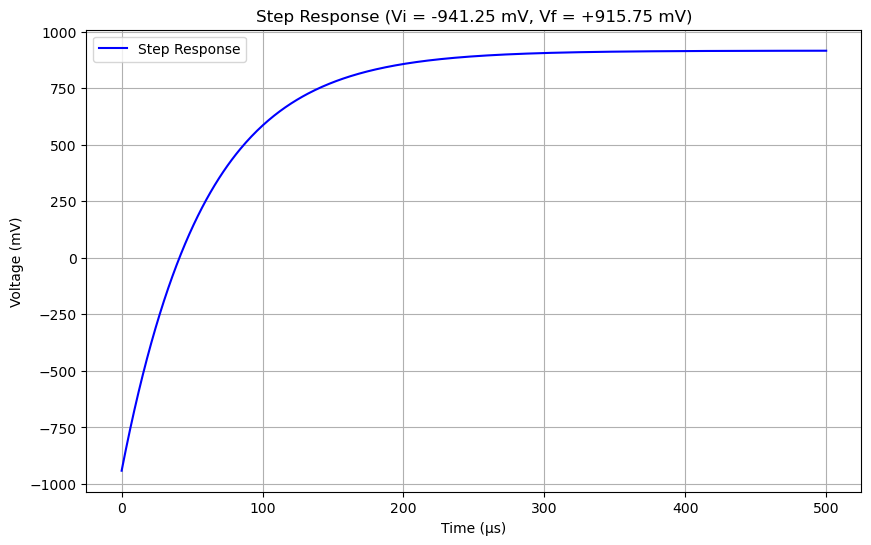

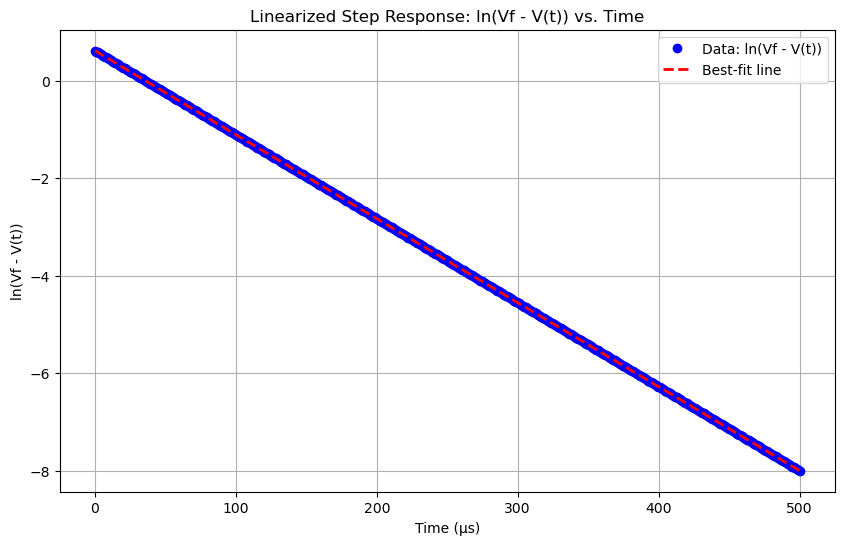

Fitted linear parameters:
  Y-intercept: 6.19e-01 ± 1.76e-15
  Slope:       -1.72e+04 ± 6.08e-12
Calculated time constant (tau): 5.80e-05 s ± 2.04e-20 s


In [99]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# Given information (in volts):
Vi_step = -0.94125   # Initial voltage of step response (-941.25 mV)
Vf_step =  0.91575   # Final voltage of step response (+915.75 mV)
tau_true = 58e-6     # True time constant = 58 microseconds

# The total voltage change for the step is:
V0 = Vf_step - Vi_step  # Should be about 1.857 V

# Create a time vector for the step response from 0 to 500 microseconds.
t_step = np.linspace(0, 500e-6, 500)  # time in seconds

# Define the step response function:
# V(t) = Vf + (Vi - Vf)*exp(-t/tau)
def step_response(t, tau):
    return Vf_step + (Vi_step - Vf_step) * np.exp(-t / tau)

# Compute the step response using the true tau (for simulation)
V_step = step_response(t_step, tau_true)

# For the linearization, we use the fact that for an RC charging process:
# Vf - V(t) = V0 * exp(-t/tau)
# Taking the natural logarithm gives:
# ln(Vf - V(t)) = ln(V0) - t/tau
# We'll compute ln(Vf - V(t)) from our simulated data.
diff_step = Vf_step - V_step
ln_diff_step = np.log(diff_step)

# Now we perform a linear fit to ln_diff_step vs. t
def linear_func(t, intercept, slope):
    return intercept + slope * t

popt, pcov = curve_fit(linear_func, t_step, ln_diff_step)
intercept_fit, slope_fit = popt
intercept_err, slope_err = np.sqrt(np.diag(pcov))

# Calculate the time constant from the slope.
# The theoretical relation is: slope = -1/tau, so:
tau_fitted = -1.0 / slope_fit
tau_fitted_err = tau_fitted * (slope_err / abs(slope_fit))

# Plot the original step response
plt.figure(figsize=(10,6))
plt.plot(t_step * 1e6, V_step * 1e3, 'b-', label='Step Response')
plt.xlabel('Time (µs)')
plt.ylabel('Voltage (mV)')
plt.title('Step Response (Vi = -941.25 mV, Vf = +915.75 mV)')
plt.grid(True)
plt.legend()
plt.show()

# Plot the logarithm of the voltage difference along with the best-fit line
plt.figure(figsize=(10,6))
plt.plot(t_step * 1e6, ln_diff_step, 'bo', label='Data: ln(Vf - V(t))')
t_fit = np.linspace(t_step.min(), t_step.max(), 200)
plt.plot(t_fit * 1e6, linear_func(t_fit, intercept_fit, slope_fit),
         'r--', linewidth=2, label='Best-fit line')
plt.xlabel('Time (µs)')
plt.ylabel('ln(Vf - V(t))')
plt.title('Linearized Step Response: ln(Vf - V(t)) vs. Time')
plt.grid(True)
plt.legend()
plt.show()

# Print the linear fit parameters and the computed tau
print("Fitted linear parameters:")
print("  Y-intercept: {:.2e} ± {:.2e}".format(intercept_fit, intercept_err))
print("  Slope:       {:.2e} ± {:.2e}".format(slope_fit, slope_err))
print("Calculated time constant (tau): {:.2e} s ± {:.2e} s".format(tau_fitted, tau_fitted_err))


# Figure 3

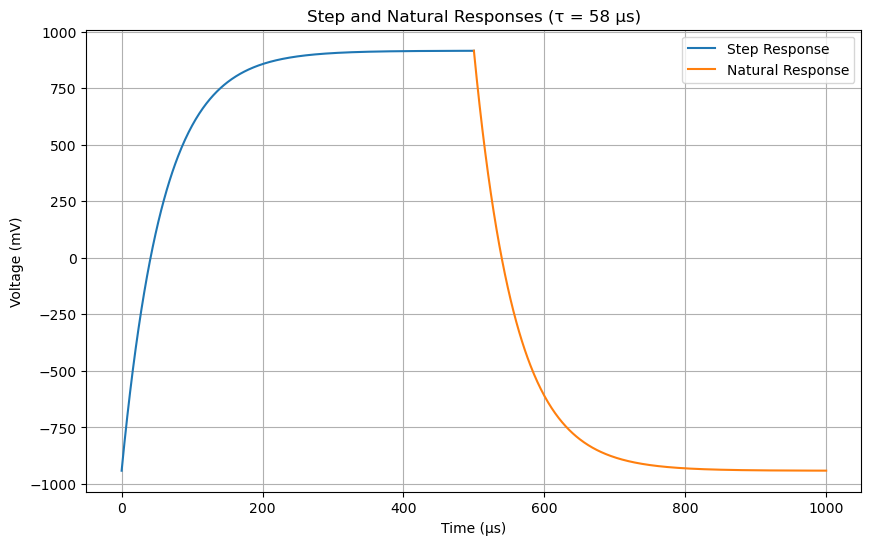

In [95]:
import numpy as np
import matplotlib.pyplot as plt

# Given information (in volts):
# Step response: initial = -941.25 mV, final = +915.75 mV
# Natural response: initial = +915.75 mV, final = -941.25 mV
# Both have a measured tau = 58 microseconds

Vi_step = -0.94125   # -941.25 mV in volts
Vf_step =  0.91575   #  915.75 mV in volts
Vi_nat  =  0.91575   #  915.75 mV in volts
Vf_nat  = -0.94125   # -941.25 mV in volts
tau     = 58e-6      # 58 microseconds in seconds

# Time arrays for plotting:
#  1) Step response from t=0 to 500 microseconds
#  2) Natural response from t=500 microseconds to 1000 microseconds
t_step = np.linspace(0, 500e-6, 500)   # 0 → 500 μs
t_nat  = np.linspace(500e-6, 1000e-6, 500)  # 500 → 800 μs

# Define the exponential step response:
#   V_step(t) = Vf_step + (Vi_step - Vf_step)*exp(-t/tau)
def step_response(t):
    return Vf_step + (Vi_step - Vf_step)*np.exp(-t / tau)

# Define the natural (discharge) response:
#   V_nat(t) = Vf_nat + (Vi_nat - Vf_nat)*exp(-(t - t0)/tau), for t >= t0=500 μs
def natural_response(t):
    t0 = 500e-6  # The discharge starts at 500 μs
    return Vf_nat + (Vi_nat - Vf_nat)*np.exp(-(t - t0) / tau)

# Compute the voltages
V_step = step_response(t_step)
V_nat  = natural_response(t_nat)

# Plot both on one figure
plt.figure(figsize=(10,6))

# Convert time to microseconds and voltage to millivolts for readability
plt.plot(t_step * 1e6, V_step * 1e3, label='Step Response')
plt.plot(t_nat  * 1e6, V_nat  * 1e3, label='Natural Response')

plt.xlabel('Time (µs)')
plt.ylabel('Voltage (mV)')
plt.title('Step and Natural Responses (τ = 58 µs)')
plt.grid(True)
plt.legend()
plt.show()


# Figure 4

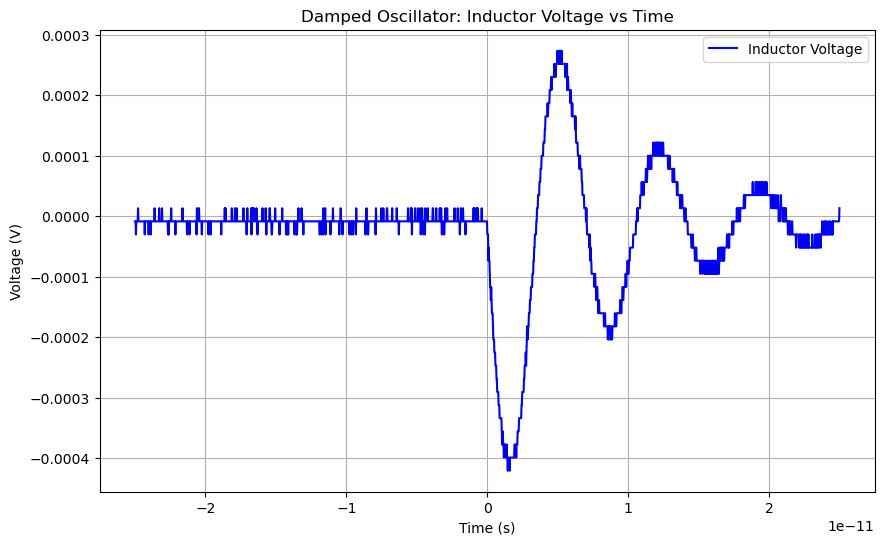

Estimated time constant (tau) from envelope peaks: 7.22e-06 s


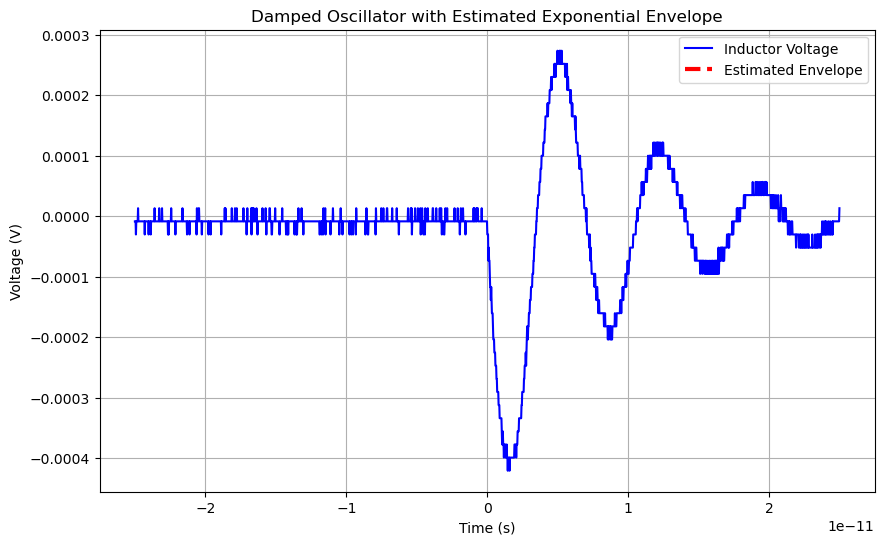

In [35]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# --- Load and Prepare Data ---
# Load the CSV file. Since your CSV appears to have 3 columns, we handle that.
data = pd.read_csv('songgun8.csv', header=None)

# Determine the number of columns and assign names accordingly.
if data.shape[1] == 2:
    data.columns = ['Time', 'Voltage']
elif data.shape[1] == 3:
    data.columns = ['Time', 'Voltage', 'Extra']  # 'Extra' column is ignored in this analysis.
else:
    raise ValueError("Unexpected number of columns in CSV file.")

# Convert 'Time' and 'Voltage' columns to numeric values
data['Time'] = pd.to_numeric(data['Time'], errors='coerce')
data['Voltage'] = pd.to_numeric(data['Voltage'], errors='coerce')

# Convert time from microseconds to seconds
time = data['Time'].values          # in microseconds
time_sec = time * 1e-6              # in seconds

# Convert voltage from mV to Volts
voltage = data['Voltage'].values * 1e-3  # in Volts

# --- Plot the Raw Damped Oscillation Signal ---
plt.figure(figsize=(10, 6))
plt.plot(time_sec, voltage, label='Inductor Voltage', color='blue')
plt.xlabel('Time (s)')
plt.ylabel('Voltage (V)')
plt.title('Damped Oscillator: Inductor Voltage vs Time')
plt.legend()
plt.grid(True)
plt.show()

# --- Estimating the Time Constant from the Envelope ---
# Given envelope peak points from your measurement:
#   (5.1 μs, 263.25 mV) and (12.0 μs, 101.25 mV)
t1_us, t2_us = 5.1, 12.0            # in microseconds
V1_mV, V2_mV = 263.25, 101.25         # in millivolts

# Convert these to SI units:
t1 = t1_us * 1e-6                   # seconds
t2 = t2_us * 1e-6                   # seconds
V1 = V1_mV * 1e-3                   # Volts
V2 = V2_mV * 1e-3                   # Volts

# For an exponential envelope: V(t) = A * exp(-t/τ)
# At t1: V1 = A * exp(-t1/τ) and at t2: V2 = A * exp(-t2/τ)
# Taking the ratio gives: V1/V2 = exp((t2-t1)/τ)
# Solving for τ:
tau_est = (t2 - t1) / np.log(V1/V2)
print("Estimated time constant (tau) from envelope peaks: {:.2e} s".format(tau_est))

# --- Plotting the Estimated Exponential Envelope ---
# Reconstruct the envelope using the exponential decay:
# Using the value at t1, solve for A: A = V1 * exp(t1/τ)
A = V1 * np.exp(t1 / tau_est)

# Define the envelope function
def envelope(t):
    return A * np.exp(-t / tau_est)

# Generate a fine time array for plotting the envelope
t_envelope = np.linspace(time_sec.min(), time_sec.max(), 500)
envelope_values = envelope(t_envelope)

plt.figure(figsize=(10, 6))
plt.plot(time_sec, voltage, label='Inductor Voltage', color='blue')
plt.plot(t_envelope, envelope_values, color='red', linestyle='--', linewidth=3, label='Estimated Envelope')
plt.xlabel('Time (s)')
plt.ylabel('Voltage (V)')
plt.title('Damped Oscillator with Estimated Exponential Envelope')
plt.legend()
plt.grid(True)
plt.show()


# Figure 5

Calculated tau = 7.221263581831692e-06 seconds
Calculated V0 = 0.5334427425578737 volts


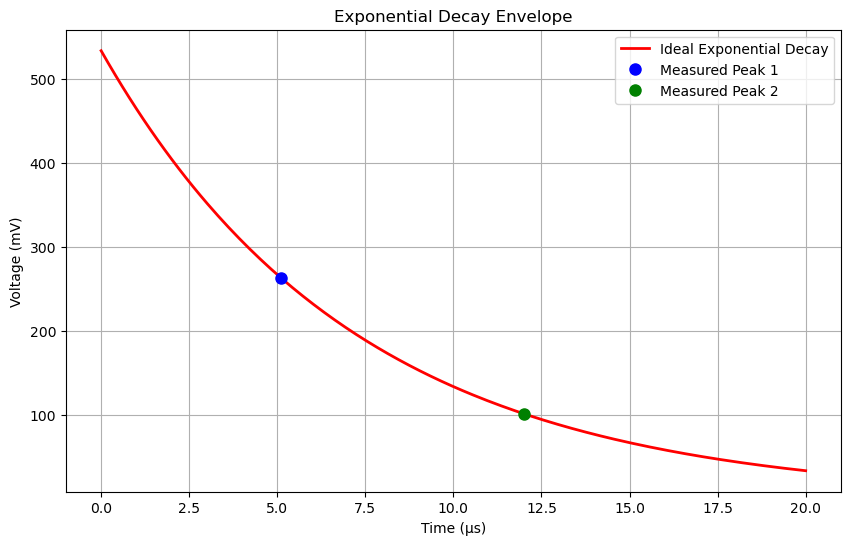

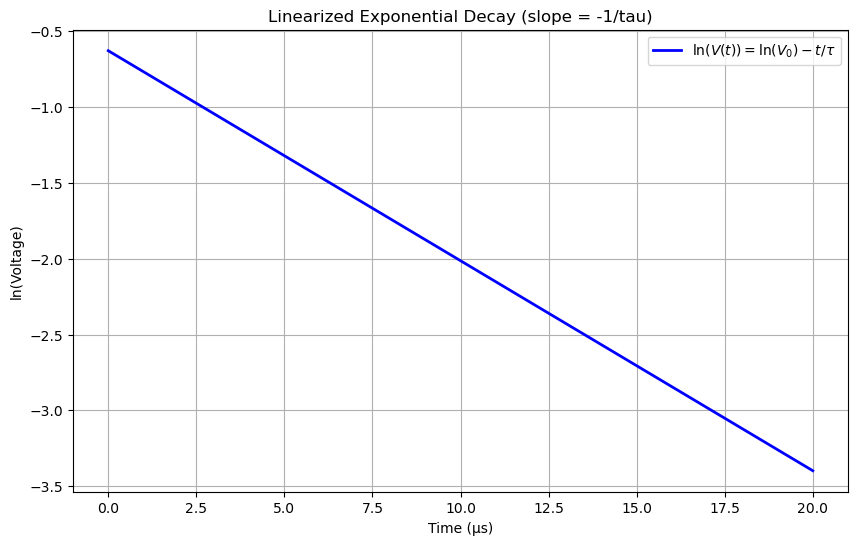

Theoretical intercept (ln(V0)) = -0.6284035381651645
Theoretical slope (-1/tau) = -138479.91956919365


In [113]:
import numpy as np
import matplotlib.pyplot as plt

# Measured data for the envelope (in SI units):
t1 = 5.1e-6        # 5.1 microseconds
V1 = 263.25e-3     # 263.25 mV in volts
t2 = 12.0e-6       # 12.0 microseconds
V2 = 101.25e-3     # 101.25 mV in volts

# Calculate the decay time constant tau using:
# tau = (t2 - t1) / ln(V1/V2)
tau = (t2 - t1) / np.log(V1/V2)
print("Calculated tau =", tau, "seconds")  # Expected ~7.22e-6 s

# Calculate V0 from the first point: V1 = V0 * exp(-t1/tau)
V0 = V1 * np.exp(t1/tau)
print("Calculated V0 =", V0, "volts")

# Create a time array for the envelope, e.g., 0 to 20 microseconds
t = np.linspace(0, 20e-6, 200)

# Compute the ideal envelope:
V_ideal = V0 * np.exp(-t/tau)

# --- Plot 1: Exponential Decay Envelope ---
plt.figure(figsize=(10,6))
plt.plot(t*1e6, V_ideal*1e3, 'r-', linewidth=2, label='Ideal Exponential Decay')
plt.plot(t1*1e6, V1*1e3, 'bo', markersize=8, label='Measured Peak 1')
plt.plot(t2*1e6, V2*1e3, 'go', markersize=8, label='Measured Peak 2')
plt.xlabel('Time (µs)')
plt.ylabel('Voltage (mV)')
plt.title('Exponential Decay Envelope')
plt.legend()
plt.grid(True)
plt.show()

# --- Plot 2: Linearized Plot ---
# Taking the natural logarithm:
ln_V = np.log(V_ideal)  # ln(V(t)) = ln(V0) - t/tau

plt.figure(figsize=(10,6))
plt.plot(t*1e6, ln_V, 'b-', linewidth=2, label=r'$\ln(V(t)) = \ln(V_0)-t/\tau$')
plt.xlabel('Time (µs)')
plt.ylabel('ln(Voltage)')
plt.title('Linearized Exponential Decay (slope = -1/tau)')
plt.grid(True)
plt.legend()
plt.show()

# Print the expected linear parameters:
intercept_theoretical = np.log(V0)
slope_theoretical = -1.0 / tau
print("Theoretical intercept (ln(V0)) =", intercept_theoretical)
print("Theoretical slope (-1/tau) =", slope_theoretical)
